## Lab 3: Recommender Systems With Dating Data

#### MSDS 7331
#### RJ Smith, Alex Matsunami, Cory Nichols

## Introduction

Dating is a complex business. Ask anyone who has watched television in recent years; all of the larger general dating sites claim to have the best "matching" capabilities. Some even claim to be optimized for farmers or other niche categories part of what we can call the "dating universe." With millions of people utilizing online dating services, it is only natural then to optimize a recommendation system for users to easily find optimal matches or dates.

## Business Understanding

## Data Understanding

### Data Files
Data is available from the following location: http://www.occamslab.com/petricek/data/

#### ratings.txt Features Breakdown:

**UserID**: Dating Site User Identifier, a string representation used to identify the user.

**ProfileId**: The UserID of the person being rated, a string representation

**Rating** -- On scale of 1-10 (10 being best), how did the user rate the profile?

#### Side Data: gender.txt

**UserID** -- Dating Site User Identifier 

**Gender** -- The Gender (M=Male, F=Female, U=unknown) of the User

## Modeling and Evaluation

Before we dive into recommender systems, we must ensure our data:

1. Is prepared for machine learning algorithms
2. Is relevant for our objective: recommending new users for dating consideration

Recommender systems normally utilize a set of items or users and items, along with optional features as part of a linear model to predict ratings or calculate similarities between items. Our training set contains a user id, another user that was rated by our user id and a rating or score. This is an interesting dilemma, often not common to recommenders for music or movies. In our case, we essentially have created a user-user matrix. There is an obvious relationship between the users doing the rating and the users being rated which may imply an item-item (user-user) recommender be used. We will investigate multiple recommender models to determine which works the best.

Even though our data is in relatively good shape, let's clean up a bit more and see if we can discover any high level relationships or information about the data that is not readily apparently on basic inspection.

### Exploratory Data Analysis and Data Preparation

This notebook requires GraphLab to run. License can be obtained below, which will then give page with pip install instructions. https://dato.com/download/

pip install --upgrade --no-cache-dir https://get.graphlab.com/GraphLab-Create/2.1/richard@smu.edu/XXXX-XXXX-XXXX-XXXX-XXXX-XXXX-XXXX-XXXX/GraphLab-Create-License.tar.gz

Afterwards, update Jupyter: conda install ipython-notebook

Uncomment the get_dependencies below and run. It will fail on setting the canvas target. Restart the Jupyter notebook, and all should be good.

In [151]:
import graphlab as gl
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
gl.canvas.set_target("ipynb")

In [152]:
ratings = gl.SFrame.read_csv('ratings.dat', header=False, verbose=False)
genders = gl.SFrame.read_csv('gender.dat', header=False, verbose=False)

Let's rename our dataset for ease of use and understanding:

In [153]:
ratings.rename({'X1':'user_id',
              'X2':'user_rated',
              'X3':'score'})

genders.rename({'X1':'user_id',
              'X2':'gender'})

print ratings, genders

+---------+------------+-------+
| user_id | user_rated | score |
+---------+------------+-------+
|    1    |    133     |   8   |
|    1    |    720     |   6   |
|    1    |    971     |   10  |
|    1    |    1095    |   7   |
|    1    |    1616    |   10  |
|    1    |    1978    |   7   |
|    1    |    2145    |   8   |
|    1    |    2211    |   8   |
|    1    |    3751    |   7   |
|    1    |    4062    |   3   |
+---------+------------+-------+
[17359346 rows x 3 columns]
Note: Only the head of the SFrame is printed.
You can use print_rows(num_rows=m, num_columns=n) to print more rows and columns. +---------+--------+
| user_id | gender |
+---------+--------+
|    1    |   F    |
|    2    |   F    |
|    3    |   U    |
|    4    |   F    |
|    5    |   F    |
|    6    |   F    |
|    7    |   F    |
|    8    |   M    |
|    9    |   M    |
|    10   |   M    |
+---------+--------+
[220970 rows x 2 columns]
Note: Only the head of the SFrame is printed.
You can use prin

Right off the bat, we can see our side data contains some unknowns identified as 'U'. Let's visually inspect our data to get an idea about the distribution and frequency of some of the features.

In [154]:
ratings['user_id'] = ratings['user_id'].astype(str)
ratings['user_rated'] = ratings['user_rated'].astype(str)
genders['user_id'] = genders['user_id'].astype(str)
ratings.show(), genders.show()

(None, None)

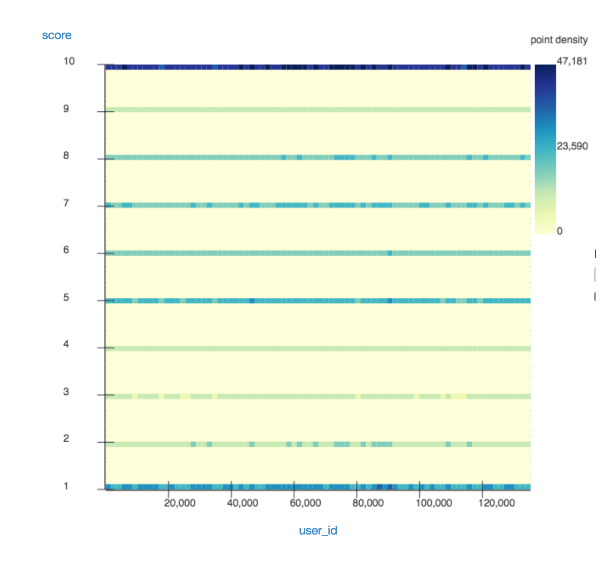

In [155]:
t = plt.imread('ratings.png')
plt.figure(figsize=(10,10))
plt.axis('off')
plt.imshow(t)
plt.show()

The distribution of scores in our dataset ranges from 1 to 10 with a mean score of 5.9 and a median of 6. Roughly 135,000 users provided ratings while 173,000 were rated. Obviously some users are being rated by users who they have also rated. There is quite a bit of variablility in ratings, however, with a standard deviation of 3.1. We can see users like to rate heavily on the extremes and middles, with 1, 10 and 5 being visually the most frequent in our heatmap above.

Our side information in this case, gender, shows that many users in our dataset have an unknown gender. This will affect our recommender's performance should we choose to incorporate side information into our models.

Further, because we do not have sexual orientation information, let's explore the dataset a bit more to see if users are rating multiple genders or if we have a more traditional dating situation where females only rate males and vice versa.

In [156]:
# join the rater's gender onto the ratee's gender
complete = ratings.join(genders).join(genders,on={'user_rated':'user_id'})
# rename for simplicity
complete.rename({'gender':'user_gender',
                 'gender.1':'gender_rated'})
# show a snapshot of complete SFrame
complete

user_id,user_rated,score,user_gender,gender_rated
1,133,8,F,M
1,720,6,F,F
1,971,10,F,M
1,1095,7,F,M
1,1616,10,F,M
1,1978,7,F,M
1,2145,8,F,M
1,2211,8,F,M
1,3751,7,F,M
1,4062,3,F,M


Notice the user rating above -- our female user_id 1 rated another female a 6.

Let's split up the ratings and take a more in depth look at how and who they are rating

In [157]:
# split out male and female ratings
female_ratings = complete[complete['user_gender'] == 'F']['user_id','user_rated','score','gender_rated']
male_ratings =  complete[complete['user_gender'] == 'M']['user_id','user_rated','score','gender_rated']

# print counts and show distributions
print 'Female ratings:\n', female_ratings.show(), '\n\nMale ratings:\n', male_ratings.show()
print 'Female rating female count: {0}'.format(sum(female_ratings['gender_rated'] =='F'))
print 'Male rating male count: {0}'.format(sum(male_ratings['gender_rated'] =='M'))

Female ratings:


None 

Male ratings:


None
Female rating female count: 1243590
Male rating male count: 682710


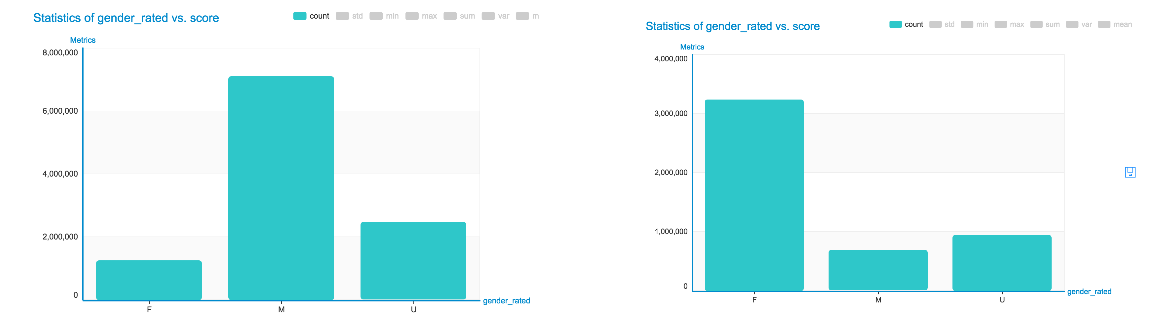

In [158]:
# create another view
f = plt.imread('female_ratings.png')
m = plt.imread('male_ratings.png')
fig, ax = plt.subplots(1, 2, figsize=(20,10))
ax[0].imshow(f)
ax[0].axis('off')
ax[1].imshow(m)
ax[1].axis('off')
plt.show()

Our data cleaning looks to be successful. The female set contains ratings from roughly 60,000 female users while the male set contains roughly the same number of users' ratings. Breaking out this dataset based on male to female or female to male recommenders would not be optimal as there are significant amounts of male to male and female to female ratings, as well as gender to unknown ratings.

Ensuring global orientations are taken into account will be critical for the success of our recommender. Users utilizing our recommender could easily identify their preference (if necessary) upon launching our dating application which will easily filter top recommendations based on gender. We will examine this functionality in detail shortly.

Thus, we will not split the dataset. Now let's get to the fun part and take a look at which users are the most popular.

## Data Modeling: The Popularity Recommender

First, let's randomly split out our dataset into training and test sets. Since we have roughly 135,000 unique users and our gender distributions are not egregiously uneven, though contain unknowns, utilizing a max number of users equal to ten percent of our dataset should work just fine for testing. This percentage works out to about 13,500 users, however, we'll round up to 14,000. From each of these users, we'll pull 20% of their ratings for our test set and retain the rest of the 80% for training. We use a higher amount for testing ratings here as each randomly selected user could have many, or few, ratings. To be conservative, we want to test on more data to decrease the chance we grab anomalies randomly and receive poor performance ratings on our recommenders.

In [159]:
user_genders = genders.copy()
item_genders = genders.rename({'user_id':'user_rated'})
genders.rename({'user_rated':'user_id'})

user_id,gender
1,F
2,F
3,U
4,F
5,F
6,F
7,F
8,M
9,M
10,M


In [160]:
train, test = gl.recommender.util.random_split_by_user(ratings,
                                                       user_id='user_id', item_id='user_rated',
                                                       max_num_users=14000, item_test_proportion=0.3)

pop = gl.recommender.popularity_recommender.create(train, 
                                                   user_id='user_id',
                                                   item_id='user_rated',
                                                   target='score',
                                                   #only_top_k=5,
                                                   verbose=False)

Recsys training: model = popularity

We could feed in side data into our popularity model to take into account the associated genders, ensuring that a linear term for the genders who have been rated (items) are included in our model and capturing the relationship between the ratings and those rated, as there is a natural relationship between the user-user setup in our dataset, though it may not matter much in a popularity model. That being said, the current way our popularity model is set up takes only the highest rated users according to score and recommends them, regardless of gender. We are more interested in establishing a baseline popularity model and will consider side data in more complex models shortly.

Let's take a look at the popularity model breakdown quickly:

In [161]:
pop.show()

Now, let's create a unique user list and utilize this list to make some initial recommendations

In [162]:
# create a unique user list and get top 5 recommendations for the first user
user_list = ratings['user_id'].unique()
recs = pop.recommend(user_list[5000:5001], k=5)
recs

user_id,user_rated,score,rank
95290,120342,10.0,1
95290,88179,10.0,2
95290,83622,10.0,3
95290,73611,10.0,4
95290,22915,10.0,5


In [163]:
recs = recs.join(genders).join(genders, on={'user_rated':'user_id'}).rename({'gender.1':'gender_recommended'})

In [164]:
recs.sort('rank')

user_id,user_rated,score,rank,gender,gender_recommended
95290,120342,10.0,1,M,M
95290,88179,10.0,2,M,M
95290,83622,10.0,3,M,M
95290,73611,10.0,4,M,M
95290,22915,10.0,5,M,M


Let's do a little more digging and look at one user, 22915, from the recommended list above, to see who rated them:

In [169]:
ratings[ratings['user_rated'] == '22915'].join(genders).join(genders,
                                                           on={'user_rated':'user_id'}).\
                                                           rename({'gender.1':'user_gender'})

user_id,user_rated,score,gender,user_gender
1,22915,10,F,M
73,22915,10,F,M
1031,22915,10,F,M
2552,22915,10,F,M
3326,22915,10,F,M
3406,22915,10,F,M
3812,22915,10,F,M
4664,22915,10,F,M
5105,22915,10,F,M
5132,22915,10,U,M


This user is a male who had mostly known females rate him a 10, lucky guy! However, our popularity model does have some drawbacks. Since we are using rating, we are only taking into account users with the highest mean ratings. The previous user had 237 ratings, but in stark contrast user 120342 is also recommended, however, has only receive ONE rating:

In [170]:
ratings[ratings['user_rated'] == '120342'].join(genders).join(genders, on={'user_rated':'user_id'})

user_id,user_rated,score,gender,gender.1
1,120342,10,F,M


This is an obvious limitation of the popularity model based on ratings in GraphLab. However, it will more than suffice as a baseline to test against in the future or use for users where no data is available.

However, the five most popular users based on ratings and the number of times they have been rated are users 120342, 88179, 83622, 73611, and 22915. The above query matches the first male user with the five most popular users based on our popularity recommender, who happen to all be male. Our basic popularity recommender is only considering the highest and most frequently rated users in the dataset.

We obviously get back a male to male recommendation situation. However, we do not know the orientation of this user, further the popularity model simply gives us the most popular users, which would not be optimal for all situations, especially in dating. However, using the popularity model as a baseline to compare additional recommenders is not a bad idea.

In [171]:
pop_eval = pop.evaluate(test, verbose=False)

In [172]:
print 'Overall RMSE: {0:.3}\n\nOverall Precision & Recall by Cutoff:\n{1}'.format(pop_eval['rmse_overall'],
                                                                                  pop_eval['precision_recall_overall'])

Overall RMSE: 2.04

Overall Precision & Recall by Cutoff:
+--------+-------------------+-------------------+
| cutoff |     precision     |       recall      |
+--------+-------------------+-------------------+
|   1    |        0.0        |        0.0        |
|   2    |        0.0        |        0.0        |
|   3    |        0.0        |        0.0        |
|   4    | 1.78571428571e-05 | 2.97619047619e-06 |
|   5    | 4.28571428571e-05 | 4.35038868357e-06 |
|   6    |  4.7619047619e-05 | 6.73134106453e-06 |
|   7    | 6.12244897959e-05 | 8.78241141457e-06 |
|   8    | 5.35714285714e-05 | 8.78241141457e-06 |
|   9    |  4.7619047619e-05 | 8.78241141457e-06 |
|   10   | 4.28571428571e-05 | 8.78241141457e-06 |
+--------+-------------------+-------------------+
[18 rows x 3 columns]
Note: Only the head of the SFrame is printed.
You can use print_rows(num_rows=m, num_columns=n) to print more rows and columns.


Our popularity model across all genders is quite terrible, with extremely low precision and recall. RMSE is not quite as bad, however it is not optimal at predicting user ratings, with an error of roughly two points, meanining on average we are off two rating points. 

As an aside, if we want to only recommend males to a female, we can perform the following:

In [173]:
# get only known males to restrict recommendations!
genders_m = genders[genders['gender']=='M']['user_id']
pop.recommend(user_list[0:1], items=genders_m, k=5).join(user_genders).sort('rank')

user_id,user_rated,score,rank,gender
64985,120342,10.0,1,F
64985,88179,10.0,2,F
64985,83622,10.0,3,F
64985,73611,10.0,4,F
64985,22915,10.0,5,F


In [174]:
# or known females to a male
genders_f = genders[genders['gender']=='F']['user_id']
pop.recommend(user_list[0:1], items=genders_f, k=5).join(user_genders).sort('rank')

user_id,user_rated,score,rank,gender
64985,78888,10.0,1,F
64985,51780,10.0,2,F
64985,18634,10.0,3,F
64985,7179,10.0,4,F
64985,79151,10.0,5,F


Obviously, though, we'd need to refine our recommenders to ensure our users have the best recommendations possible. Popularity models are nice for twitter, however, they won't work for dating in most cases. We will now explore more advanced recommendation options and utilize side data to improve our recommendation engine and compare it to the base popularity model.

## Additional Recommender Options

### Ranked Factorization Matrix

Our first attempt at creating a more robust recommender will be a Ranked Factorization Matrix. Since we have explicit data with ratings included in our observations, we can do one of two things with matrix factorization:

1. Predict the rating a user would give
2. Recommend items we believe the user would rate highly


Many excerpts found from graphlab documentation

The RankingFactorizationRecommender in GraphLab tries to recommend items that are both similar to the items in a user's dataset and, if rating information is provided, those that would be rated highly by the user. The trade off with this recommender is that we will likely have less predictive accuracy but better precision and recall. This is due to the fact that the ranking method penalizes the predicted rating of items that are significantly different from the items a user has already interacted with. This ensures the model is confident in its prediction AND it predicts a high rating.

In factorization models in general, users and items are represented by weights and factors learned during model training where weights or bias terms account for a user or item's bias towards high or low ratings. An item rated high consistently would have a higher weight coefficient, for instance. There are also latent factor terms that model interactions between users and items and allow us to group users and items into categories. If a user loves romance movies and hates action movies, factor terms attempt to capture that relationship and use the model to predict lower scores for action movies and higher scores for romance movies.

This results in a linear model for each user as follows:

        score(i,j)=μ + wi + wj + aTxi + bTyj + uTivj
        
Where w's are learned weights for users and items, a and b represent side data for users and items, respectively and the last term represents the dot product of the latent variables. Mu, represents a global bias term.

Weights and latent factors are learned via stochastic gradient descent and solving for the minimization of multiple user/item bias variables, side data variables and latent variables of a complex objective function not listed here. Randomization is often incorporated, especially in the case of finding latent variables where we have missing ratings and want to predict what the user score would be.
        
With the high level overview out of the way, let's find the latent factors (using SGD) from our known data and set up our penalized linear model using graphlab's RankingFactorizationRecommender. This recommender will learn the latent factors from the data to make recommendation and rank them according to the likelihood of seeing the user, item (or in our case user-user) pair.


In [132]:
rf_rec = gl.recommender.ranking_factorization_recommender.create(train,
                                                                 user_id='user_id',
                                                                 item_id='user_rated',
                                                                 target='score',
                                                                 user_data=genders,
                                                                 verbose=False)

Recsys training: model = ranking_factorization_recommender

In [133]:
rf_rec.evaluate(test, verbose=False)

{'precision_recall_by_user': Columns:
 	user_id	int
 	cutoff	int
 	precision	float
 	recall	float
 	count	int
 
 Rows: 252000
 
 Data:
 +---------+--------+----------------+-------------------+-------+
 | user_id | cutoff |   precision    |       recall      | count |
 +---------+--------+----------------+-------------------+-------+
 |    9    |   1    |      0.0       |        0.0        |  1061 |
 |    9    |   2    |      0.0       |        0.0        |  1061 |
 |    9    |   3    | 0.333333333333 | 0.000942507068803 |  1061 |
 |    9    |   4    |      0.5       |  0.00188501413761 |  1061 |
 |    9    |   5    |      0.4       |  0.00188501413761 |  1061 |
 |    9    |   6    | 0.333333333333 |  0.00188501413761 |  1061 |
 |    9    |   7    | 0.428571428571 |  0.00282752120641 |  1061 |
 |    9    |   8    |      0.5       |  0.00377002827521 |  1061 |
 |    9    |   9    | 0.555555555556 |  0.00471253534402 |  1061 |
 |    9    |   10   |      0.5       |  0.00471253534402 |  1

Precision and recall performance is much better with a ranked factorization model rather than a popularity model. However, as mentioned prior, RMSE suffers as we are not optimizing for prediction. 

## Deployment